## Data cleaning

In [1]:

%pip install fuzzywuzzy python-Levenshtein
import pandas as pd
from fuzzywuzzy import process

def joint_data_set(df1, df2):
    merged_df = pd.concat([df1, df2], ignore_index=True)

    return merged_df

def remove_duplicates(df):
    return df.drop_duplicates()

def remove_missing_values(df):
    return df.dropna()

def find_closest_match(row, mimu_SR_Name):
    matches = process.extractOne(row, mimu_SR_Name, score_cutoff=90)
    return matches[0]

def data_cleaning(df_towns, df_villages, df_news):
    df_towns.columns = ['SR_Name', 'name']
    df_villages.columns = ['SR_Name', 'name']
    df_news.columns = ['SR_Name', 'name']
    df_towns['name'] = df_towns['name'].apply(lambda name: name.replace('Town', '').strip())
    df_mimu = joint_data_set(df_towns, df_villages)
    df_mimu = remove_missing_values(df_mimu)
    df_news = remove_duplicates(df_news)
    mimu_SR_Name = df_mimu['SR_Name'].unique()
    df_news.loc[:, 'SR_Name']  = df_news['SR_Name'].apply(lambda x: find_closest_match(x, mimu_SR_Name))
    df_mimu = joint_data_set(df_mimu, df_news)

    return df_mimu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Data preprocessing

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def remove_special_characters(text):
    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text.lower()

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove punctuation and stop words, and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word)
                      for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(cleaned_tokens)

def preprocess_textinput(df, text_column):
    vectorizer = CountVectorizer(max_features=5000)
    df['cleaned_text'] = df[text_column].apply(remove_special_characters)
    X = vectorizer.fit_transform(df['cleaned_text']).toarray()
    return X

def preprocess_category(df, column):
    df[column] = df[column].astype('category')
    mapping = dict(enumerate(df[column].cat.categories))  # id to label
    df[column] = df[column].cat.codes
    return df, mapping


def preprocess_onehot(df, column):
    df = pd.get_dummies(df, columns=[column])
    return df

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data loading

In [3]:
# Load data from files
df_towns = pd.read_excel('https://github.com/tklwin/Intro-to-Deep-Learning/raw/refs/heads/main/chapter2/Project_02/data/MMNames_mimu.xlsx', sheet_name='Towns')
df_villages = pd.read_excel('https://github.com/tklwin/Intro-to-Deep-Learning/raw/refs/heads/main/chapter2/Project_02/data/MMNames_mimu.xlsx', sheet_name='Villages')
df_news = pd.read_csv('https://github.com/tklwin/Intro-to-Deep-Learning/raw/refs/heads/main/chapter2/Project_02/data/MMNames_news.csv')
df_mimu = data_cleaning(df_towns, df_villages, df_news)

df_mimu

,SR_Name,name
0,Ayeyarwady,Bogale
1,Ayeyarwady,Danubyu
2,Ayeyarwady,Dedaye
3,Ayeyarwady,Einme
4,Ayeyarwady,Du Yar
...,...,...
19508,Sagaing,Lahe
19509,Kayin,Taung Dee
19510,Shan (South),Kho Lam
19511,Rakhine,Laung Zin


## Neural Networks Experimentation

In [4]:
import time
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = df_mimu.copy()

# Prepare the data

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df, sr_name_mapping = preprocess_category(df, 'SR_Name')
df = preprocess_onehot(df,'name')

y = df['SR_Name'].values
X = df.drop(columns=['SR_Name']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

# Define model architectures
architectures = {
    'model_2layers': [32, 16],
    'model_3layers': [64, 32, 16],
    'model_4layers': [128, 64, 32, 16],
    'model_2layers_wide': [256, 128],
    'model_3layers_wide': [256, 128, 64],
    'model_4layers_wide': [256, 128, 64, 32],
}

# Function to create model

def create_classification_model(input_shape, num_classes, hidden_layers, use_dropout=False, dropout_rate=0.1, use_batchnorm=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))

    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units))

        if use_batchnorm:
            model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.Activation('relu'))

        if use_dropout:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Experiments
results = []

for name, hidden_layers in architectures.items():
    for mode in ['baseline', 'dropout', 'batchnorm', 'both']:
        if mode == 'dropout':
            use_dropout = True
            use_batchnorm = False
            dropout_rate = 0.1
        elif mode == 'batchnorm':
            use_dropout = False
            use_batchnorm = True
            dropout_rate = 0.0
        elif mode == 'both':
            use_dropout = True
            dropout_rate = 0.1
        else:  # baseline
            use_dropout = False
            use_batchnorm = False
            dropout_rate = 0.0

        model_name = f"{name}_{mode}"
        print(f"\nTraining {model_name} | Layers: {hidden_layers} | Dropout: {use_dropout} | BatchNorm: {use_batchnorm}")

        model = create_classification_model(
            input_shape=[X_train.shape[1]],
            num_classes=len(set(y)),
            hidden_layers=hidden_layers,
            use_dropout=use_dropout,
            dropout_rate=dropout_rate,
            use_batchnorm=use_batchnorm
        )
        total_params = model.count_params()

        start_time = time.time()
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
        training_time = time.time() - start_time

        # Predictions
        y_pred_test = model.predict(X_test, batch_size=32, verbose=0).argmax(axis=1)
        y_pred_train = model.predict(X_train, batch_size=32, verbose=0).argmax(axis=1)

        test_acc = accuracy_score(y_test, y_pred_test)
        train_acc = accuracy_score(y_train, y_pred_train)

        # Save classification reports
        pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).T.round(2)\
            .to_csv(f'cls_report_{model_name}_test.csv')
        pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True)).T.round(2)\
            .to_csv(f'cls_report_{model_name}_train.csv')

        # Save results
        results.append({
            'Model': model_name,
            'Layers': hidden_layers,
            'Total Params': total_params,
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4),
            'Dropout': use_dropout,
            'BatchNorm': use_batchnorm,
            'Training Time (s)': round(training_time, 2)
        })

# Save and show summary table
results_df = pd.DataFrame(results)
results_df.to_csv('./model_comparison_summary.csv', index=False)
print("\n Model Comparison Summary:")

from tabulate import tabulate
print(tabulate(results_df, headers='keys', tablefmt='github'))

2025-06-14 07:08:57.026592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749884937.207632      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749884937.260730      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(13659, 13003) (5854, 13003)

Training model_2layers_baseline | Layers: [32, 16] | Dropout: False | BatchNorm: False


I0000 00:00:1749884951.788161      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1749884954.724979      63 service.cc:148] XLA service 0x79a71c008650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749884954.725531      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749884954.909749      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749884955.626529      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Training model_2layers_dropout | Layers: [32, 16] | Dropout: True | BatchNorm: False

Training model_2layers_batchnorm | Layers: [32, 16] | Dropout: False | BatchNorm: True

Training model_2layers_both | Layers: [32, 16] | Dropout: True | BatchNorm: True

Training model_3layers_baseline | Layers: [64, 32, 16] | Dropout: False | BatchNorm: False

Training model_3layers_dropout | Layers: [64, 32, 16] | Dropout: True | BatchNorm: False

Training model_3layers_batchnorm | Layers: [64, 32, 16] | Dropout: False | BatchNorm: True

Training model_3layers_both | Layers: [64, 32, 16] | Dropout: True | BatchNorm: True

Training model_4layers_baseline | Layers: [128, 64, 32, 16] | Dropout: False | BatchNorm: False

Training model_4layers_dropout | Layers: [128, 64, 32, 16] | Dropout: True | BatchNorm: False

Training model_4layers_batchnorm | Layers: [128, 64, 32, 16] | Dropout: False | BatchNorm: True

Training model_4layers_both | Layers: [128, 64, 32, 16] | Dropout: True | BatchNorm: True

Tra

|   ID | SR Name      |   Count |
|------|--------------|---------|
|    0 | Ayeyarwady   |    2178 |
|    1 | Bago (East)  |     921 |
|    2 | Bago (West)  |     814 |
|    3 | Chin         |     648 |
|    4 | Kachin       |     878 |
|    5 | Kayah        |     228 |
|    6 | Kayin        |     552 |
|    7 | Magway       |    2244 |
|    8 | Mandalay     |    1903 |
|    9 | Mon          |     600 |
|   10 | Nay Pyi Taw  |     234 |
|   11 | Rakhine      |    1331 |
|   12 | Sagaing      |    3278 |
|   13 | Shan (East)  |     257 |
|   14 | Shan (North) |    1476 |
|   15 | Shan (South) |     616 |
|   16 | Tanintharyi  |     524 |
|   17 | Yangon       |     831 |


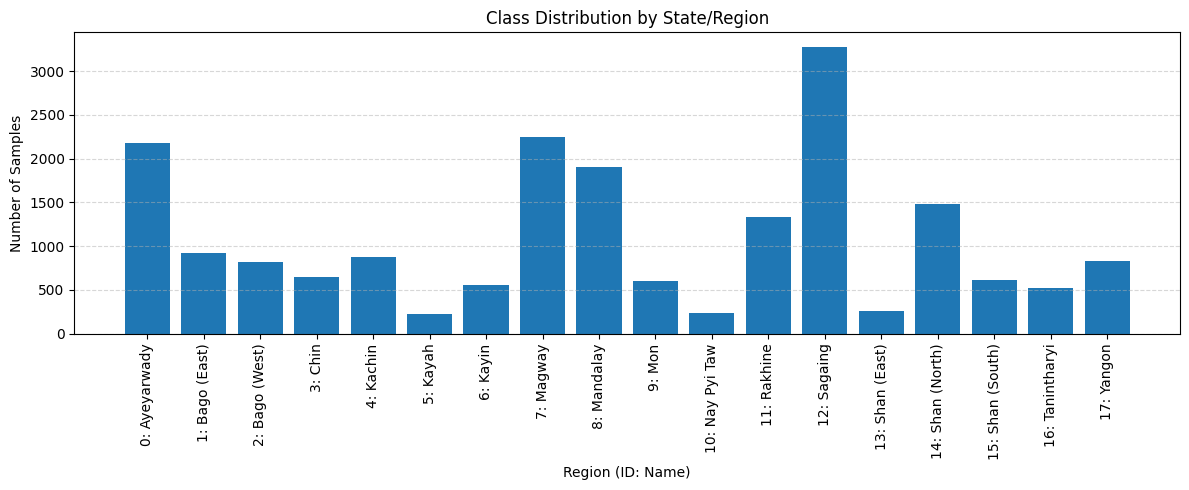

In [5]:
from tabulate import tabulate
import matplotlib.pyplot as plt


# Count how many samples per class
class_counts = df['SR_Name'].value_counts().sort_index()

summary = []
for class_id, count in class_counts.items():
    class_name = sr_name_mapping[class_id]
    summary.append([class_id, class_name, count])

print(tabulate(summary, headers=["ID", "SR Name", "Count"], tablefmt="github"))

plt.figure(figsize=(12, 5))
plt.bar([f"{i}: {sr_name_mapping[i]}" for i in class_counts.index], class_counts.values)
plt.title("Class Distribution by State/Region")
plt.xlabel("Region (ID: Name)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
region_counts = df_mimu['SR_Name'].value_counts().sort_index()
print(region_counts)


SR_Name
Ayeyarwady      2178
Bago (East)      921
Bago (West)      814
Chin             648
Kachin           878
Kayah            228
Kayin            552
Magway          2244
Mandalay        1903
Mon              600
Nay Pyi Taw      234
Rakhine         1331
Sagaing         3278
Shan (East)      257
Shan (North)    1476
Shan (South)     616
Tanintharyi      524
Yangon           831
Name: count, dtype: int64
